# Continuous Control Project

## Section 1: Setup and Imports

This section prepares the environment by updating system paths, installing dependencies (e.g., NumPy, PyTorch), and importing libraries for numerical operations, randomness, plotting, and Unity environment interaction. It also selects the computation device (GPU or CPU) for efficient processing.

In [1]:
# Update the PATH env var. 
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/home/student/.local/bin"
os.environ['PATH'] = f"{os.environ['PATH']}:/opt/conda/lib/python3.10/site-packages"
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'

In [2]:
!python -m pip freeze | grep numpy

numpy==1.26.3


In [3]:
!pip -q install .


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [4]:
!pip install torch

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


### Restart the Kernel at this step on the first run

In [5]:
# Import libraries
import numpy as np
import random
import copy
from collections import deque, namedtuple
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from unityagents import UnityEnvironment
import time
import psutil

In [6]:
# Define computation device (GPU if available, else CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Section 2: Initialize environment

Here, the Unity Reacher environment is loaded, and critical parameters—number of agents, action size (4), and state size (33)—are extracted and displayed. This confirms the environment is ready for multi-agent training.



In [7]:
# Initialize environment
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=True)[brain_name]
num_agents = len(env_info.agents)
action_size = brain.vector_action_space_size
states = env_info.vector_observations
state_size = states.shape[1]
print(f'Number of agents: {num_agents}')
print(f'Size of each action: {action_size}')
print(f'State size per agent: {state_size}')

Found path: /data/Reacher_Linux_NoVis/Reacher.x86_64
Mono path[0] = '/data/Reacher_Linux_NoVis/Reacher_Data/Managed'
Mono config path = '/data/Reacher_Linux_NoVis/Reacher_Data/MonoBleedingEdge/etc'
Preloaded 'libgrpc_csharp_ext.x64.so'
Unable to preload the following plugins:
	libgrpc_csharp_ext.x86.so
Logging to /home/student/.config/unity3d/Unity Technologies/Unity Environment/Player.log


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of agents: 20
Size of each action: 4
State size per agent: 33


## Section 3: State and Action Space Explanation

In the Reacher environment, the objective is for a double-jointed robotic arm to move its end-effector to follow a moving target as closely as possible. The environment features a continuous state space and a continuous action space, which define how the agent observes its surroundings and takes actions.

#### State Space (Observations)
The state space is a 33-dimensional continuous vector that captures the current state of the robotic arm and its relationship to the target. The components of this vector include:
- Joint Positions: Spatial coordinates of the arm's joints.

- Joint Rotations: Orientation of the joints.

- Joint Velocities: Speed of the joints' movements.

- Angular Velocities: Rate of rotation of the joints.

- Target Position: Coordinates of the moving target the arm must track.

This 33-element observation vector is updated at each time step, providing the agent with a detailed snapshot of the arm's dynamics and the target's location.



#### Action Space
The action space is continuous and consists of a 4-dimensional vector, where each value ranges from -1 to 1. These values represent the torques applied to the arm's joints:
- Action 0: Torque for the first joint.

- Action 1: Torque for the second joint.

- Action 2: Torque for the third joint.

- Action 3: Torque for the fourth joint.

By adjusting these torques, the agent controls the arm's movement to align the end-effector with the target.

## Section 4: Utility functions

- hidden_init initializes neural network weights for stability.
- cleanup_zombie_processes terminates lingering Reacher processes to free system resources.



In [8]:
def hidden_init(layer):
    """Initialize hidden layer weights with uniform distribution."""
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

In [9]:
def cleanup_zombie_processes():
    """Terminate parent processes of zombie Reacher instances."""
    for proc in psutil.process_iter(['pid', 'ppid', 'name', 'status']):
        if 'Reacher' in proc.info['name'] and proc.info['status'] == psutil.STATUS_ZOMBIE:
            print(f"Zombie process detected: {proc.info}")
            parent = psutil.Process(proc.info['ppid'])
            print(f"Terminating parent process: {parent}")
            parent.terminate()

## Section 5: Actor and Critics Networks

The Actor network maps states to actions using ReLU and tanh activations, while the Critic network estimates Q-values for state-action pairs with leaky ReLU activations. Both use feedforward architectures with weight initialization for training stability.



In [10]:
class Actor(nn.Module):
    """Actor network mapping states to actions."""
    def __init__(self, state_size, action_size, seed, fc1_units=400, fc2_units=300):
        """
        Args:
            state_size (int): State dimension
            action_size (int): Action dimension
            seed (int): Random seed for reproducibility
            fc1_units (int): Units in first hidden layer
            fc2_units (int): Units in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.bn1 = nn.BatchNorm1d(fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        """Set initial weights using uniform distribution."""
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Map state to action using ReLU and tanh activations."""
        x = F.relu(self.bn1(self.fc1(state)))
        x = F.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))

In [11]:
class Critic(nn.Module):
    """Critic network estimating Q-values for state-action pairs."""
    def __init__(self, state_size, action_size, seed, fcs1_units=400, fc2_units=300):
        """
        Args:
            state_size (int): State dimension
            action_size (int): Action dimension
            seed (int): Random seed for reproducibility
            fcs1_units (int): Units in first hidden layer
            fc2_units (int): Units in second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.bn1 = nn.BatchNorm1d(fcs1_units)
        self.fc2 = nn.Linear(fcs1_units + action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        """Set initial weights using uniform distribution."""
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Map (state, action) to Q-value using leaky ReLU activations."""
        xs = F.leaky_relu(self.bn1(self.fcs1(state)))
        x = torch.cat((xs, action), dim=1)
        x = F.leaky_relu(self.fc2(x))
        return self.fc3(x)

## Section 6: Replay Buffer and Ornstein-Uhlenbeck Noise

The Replay Buffer stores experience tuples (state, action, reward, next state, done) for off-policy learning, sampling random batches. The OUNoise class adds exploration noise to actions using the Ornstein-Uhlenbeck process, aiding policy discovery.



In [12]:
class ReplayBuffer:
    """Buffer storing experience tuples for off-policy learning."""
    def __init__(self, action_size, buffer_size, batch_size, seed):
        """
        Args:
            action_size (int): Action dimension
            buffer_size (int): Maximum buffer capacity
            batch_size (int): Size of sampled batches
            seed (int): Random seed for reproducibility
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Store a new experience tuple."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Sample a random batch of experiences."""
        experiences = random.sample(self.memory, k=self.batch_size)
        states = torch.from_numpy(np.vstack([e.state for e in experiences])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences]).astype(np.uint8)).float().to(device)
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return current buffer size."""
        return len(self.memory)


In [13]:
class OUNoise:
    """Ornstein-Uhlenbeck noise for action exploration."""
    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """
        Args:
            size (int): Action dimension
            seed (int): Random seed for reproducibility
            mu (float): Mean of noise
            theta (float): Drift coefficient
            sigma (float): Volatility coefficient
        """
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset noise state to mean."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Generate noise sample and update internal state."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(len(x))
        self.state = x + dx
        return self.state

## Section 7: DDPG Agent

The DDPG Agent class combines actor and critic networks, noise, and replay buffer. It handles action selection, learning updates via sampled experiences, and smooth target network updates using a soft update mechanism.



In [14]:
class Agent:
    """DDPG agent for environment interaction and learning."""
    def __init__(self, state_size, action_size, random_seed):
        """
        Args:
            state_size (int): State dimension
            action_size (int): Action dimension
            random_seed (int): Random seed for reproducibility
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)

        # Actor networks
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic networks
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Exploration noise
        self.noise = OUNoise(action_size, random_seed)

        # Experience replay
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)

    def step(self, state, action, reward, next_state, done):
        """Add experience to buffer."""
        self.memory.add(state, action, reward, next_state, done)

    def act(self, state, add_noise=True):
        """Generate action for a given state."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample()
        return np.clip(action, -1, 1)

    def reset(self):
        """Reset noise process."""
        self.noise.reset()

    def start_learn(self):
        """Trigger learning if buffer has sufficient samples."""
        if len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

    def learn(self, experiences, gamma):
        """
        Update networks using a batch of experiences.
        
        Args:
            experiences (tuple): Batch of (state, action, reward, next_state, done)
            gamma (float): Discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # Update critic
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()

        # Update actor
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Update target networks
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)

    def soft_update(self, local_model, target_model, tau):
        """Update target network parameters smoothly.
        
        Args:
            local_model (nn.Module): Source model
            target_model (nn.Module): Target model
            tau (float): Interpolation factor
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)

## Section 8: Training the Agent

This section sets hyperparameters (e.g., buffer size, learning rates) and defines the DDPG training loop. The agent interacts with the environment, learns from experiences, and tracks scores until achieving a goal (average score ≥ 30). Results are plotted for analysis.



In [15]:
# Hyperparameters
BUFFER_SIZE = int(1e6)  # Replay buffer capacity
BATCH_SIZE = 1024       # Minibatch size for learning
GAMMA = 0.99            # Discount factor for future rewards
TAU = 1e-3              # Soft update interpolation parameter
LR_ACTOR = 1e-3         # Actor network learning rate
LR_CRITIC = 1e-3        # Critic network learning rate
WEIGHT_DECAY = 0        # L2 weight decay for critic optimization

In [16]:
# Initialize agent
random_seed = 0
agent = Agent(state_size=state_size, action_size=action_size, random_seed=random_seed)

In [17]:
# DDPG training function
def ddpg(n_episodes=2000, max_t=1000, print_every=10, learn_every=20, num_learn=10, goal_score=30):
    """
    Train DDPG agent in the Reacher environment.
    
    Args:
        n_episodes (int): Maximum number of episodes
        max_t (int): Maximum timesteps per episode
        print_every (int): Interval for printing progress
        learn_every (int): Interval for learning updates
        num_learn (int): Number of learning updates per cycle
        goal_score (float): Target average score to solve environment
    
    Returns:
        list: Scores per episode
    """
    scores_deque = deque(maxlen=100)
    scores = []

    for i_episode in range(1, n_episodes + 1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        agent.reset()
        episode_scores = np.zeros(num_agents)
        start_time = time.time()

        for t in range(max_t):
            actions = agent.act(states, add_noise=True)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done

            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, done)

            states = next_states
            episode_scores += rewards

            if t % learn_every == 0:
                for _ in range(num_learn):
                    agent.start_learn()

            if any(dones):
                break

        duration = time.time() - start_time
        mean_score = np.mean(episode_scores)
        scores_deque.append(mean_score)
        scores.append(mean_score)
        avg_score = np.mean(scores_deque)

        print(f'\rEpisode {i_episode}\tAvg Score: {avg_score:.2f}\tMean: {mean_score:.2f}\t'
              f'Min: {np.min(episode_scores):.2f}\tMax: {np.max(episode_scores):.2f}\tTime: {duration:.2f}s')

        if i_episode % print_every == 0:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            print(f'\rEpisode {i_episode}\tAvg Score: {avg_score:.2f}\tTime: {duration:.2f}s')

        if avg_score >= goal_score and i_episode >= 100:
            print(f'\nEnvironment solved in {i_episode} episodes!\tAverage Score: {avg_score:.2f}')
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break

    return scores


In [18]:
# Train the agent
scores = ddpg()

Episode 1	Avg Score: 0.27	Mean: 0.27	Min: 0.00	Max: 0.85	Time: 232.06s
Episode 2	Avg Score: 0.30	Mean: 0.32	Min: 0.00	Max: 1.02	Time: 245.50s
Episode 3	Avg Score: 0.36	Mean: 0.49	Min: 0.00	Max: 1.21	Time: 246.40s
Episode 4	Avg Score: 0.42	Mean: 0.61	Min: 0.00	Max: 1.27	Time: 244.79s
Episode 5	Avg Score: 0.40	Mean: 0.30	Min: 0.00	Max: 0.68	Time: 244.00s
Episode 6	Avg Score: 0.42	Mean: 0.51	Min: 0.00	Max: 1.91	Time: 244.61s
Episode 7	Avg Score: 0.47	Mean: 0.77	Min: 0.18	Max: 2.49	Time: 243.50s
Episode 8	Avg Score: 0.57	Mean: 1.25	Min: 0.07	Max: 4.33	Time: 240.28s
Episode 9	Avg Score: 0.65	Mean: 1.28	Min: 0.00	Max: 2.95	Time: 232.20s
Episode 10	Avg Score: 0.75	Mean: 1.66	Min: 0.00	Max: 2.89	Time: 224.18s
Episode 10	Avg Score: 0.75	Time: 224.18s
Episode 11	Avg Score: 0.86	Mean: 2.00	Min: 0.64	Max: 4.29	Time: 226.58s
Episode 12	Avg Score: 0.99	Mean: 2.38	Min: 0.00	Max: 4.56	Time: 229.79s
Episode 13	Avg Score: 1.10	Mean: 2.50	Min: 0.16	Max: 5.50	Time: 228.72s
Episode 14	Avg Score: 1.36	Mean:

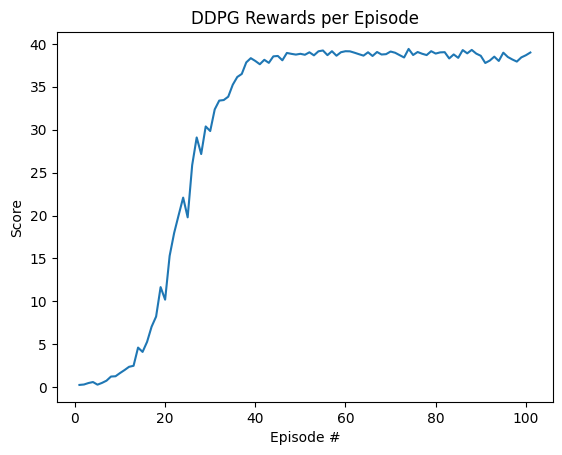

In [19]:
# Plot results
plt.plot(np.arange(1, len(scores) + 1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title('DDPG Rewards per Episode')
plt.savefig('ddpg_rewards_plot.png')
plt.show()


## Section 9: Environment Cleanup

In [3]:
# Cleanup
#env.close()
#cleanup_zombie_processes()